In [1]:
import MEArec as mr
import numpy as np
import matplotlib.pylab as plt
from pprint import pprint
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import torchsummary
import seaborn as sns

In [2]:
tempgen = mr.load_templates('templates_100_neuropixels.h5')
recgen = mr.load_recordings('recording_neuropixels_120s.h5')

In [3]:
example_plot = recgen.recordings[0:10000,0]

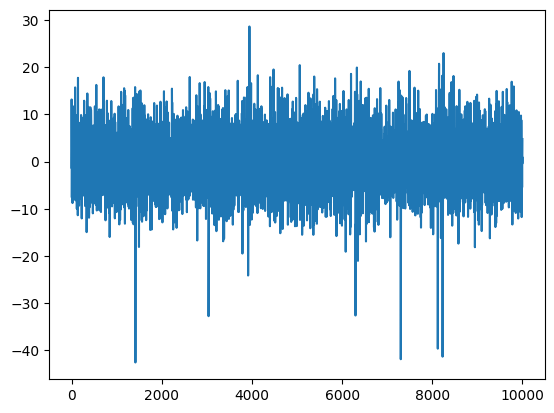

In [4]:
plt.plot(example_plot)


In [5]:
recgen.spiketrains[0]
soma_position_test = [53.67117315857896, 36.895064392826356, 1230.990825111338]


In [6]:
tempvar = 12342134
i = 0
for x,item in enumerate(recgen.channel_positions):
    if np.linalg.norm(item-soma_position_test) < tempvar:
        tempvar = np.linalg.norm(item-soma_position_test)
        location = x

In [7]:
def euclidean_distance(point1, point2):
    return np.linalg.norm(point1 - point2)

def neurons_within_distance(recgen, distance_threshold):
    neurons_within_range = []
    for probe_index, probe_position in enumerate(recgen.channel_positions):
        neurons_within_probe_range = []
        for neuron_index, neuron_position in enumerate(recgen.template_locations):
            distance = euclidean_distance(probe_position, neuron_position)
            if distance <= distance_threshold:
                neurons_within_probe_range.append((neuron_index, neuron_position))
        neurons_within_range.append(neurons_within_probe_range)
    return neurons_within_range

In [33]:
distance_threshold = 100
neurons_within_range = neurons_within_distance(recgen, distance_threshold)

In [34]:
neurons_within_range[0]

[(106, array([   16.75095395,   -11.84409562, -1886.51574703]))]

In [35]:
def mark_spikes_on_time_series(recgen, probe_index, neurons_within_probe_range):
    time_series_length = len(recgen.recordings[:, probe_index])
    spikes_row = np.zeros(time_series_length)

    for neuron_index, neuron_position in neurons_within_probe_range:
        spike_train = recgen.spiketrains[neuron_index]
        spike_times = spike_train.times.rescale('s')
        spike_times_indices = (spike_times * recgen.info['recordings']['fs']).astype(int)
        spikes_row[spike_times_indices] = 1  # Mark spike occurrences

    # Create a copy of the original recordings
    new_recordings = recgen.recordings[:, probe_index].copy()

    # Add the spikes row as a second row to the new variable
    new_recordings = np.vstack((new_recordings.T, spikes_row)).T

    return new_recordings

probe_index = 0 
neurons_within_probe_range = neurons_within_range[probe_index]
training_recording = mark_spikes_on_time_series(recgen, probe_index, neurons_within_probe_range)

In [36]:
def mark_spikes_on_time_series(recgen, probe_index, neurons_within_probe_range):
    time_series_length = len(recgen.recordings[:, probe_index])
    spikes_row = np.zeros(time_series_length)

    for neuron_index, neuron_position in neurons_within_probe_range:
        spike_train = recgen.spiketrains[neuron_index]
        spike_times = spike_train.times.rescale('s')  # Convert spike times to seconds
        spike_times_indices = (spike_times * recgen.info['recordings']['fs']).astype(int)
        spikes_row[spike_times_indices] = 1  # Mark spike occurrences

    # Create a copy of the original recordings
    new_recordings = recgen.recordings[:, probe_index].copy()

    # Add the spikes row as a second row to the new variable
    new_recordings = np.vstack((new_recordings.T, spikes_row)).T

    return new_recordings

In [37]:
num_probes = 10


train_datasets = []
test_datasets = []

for probe_index in range(num_probes):
    neurons_within_probe_range = neurons_within_range[probe_index]
    training_recording = mark_spikes_on_time_series(recgen, probe_index, neurons_within_probe_range)

    time_series = training_recording[:, 0]
    spike_series = training_recording[:, 1]

    chunk_length = int(32000 * 0.004)
    num_chunks = len(time_series) // chunk_length

    lfp_chunks = []
    spike_chunks = []

    # Split the time series data into chunks
    for i in range(num_chunks):
        start_index = i * chunk_length
        end_index = (i + 1) * chunk_length
        lfp_chunk = time_series[start_index:end_index]
        spike_chunk = spike_series[start_index:end_index]
        lfp_chunks.append(lfp_chunk)
        spike_chunks.append(spike_chunk)

    # Convert to numpy arrays and expand dimensions
    lfp_chunks = np.array(lfp_chunks)[:, np.newaxis, :]  # Shape: (num_chunks, 1, chunk_length)
    spike_chunks = np.array(spike_chunks)[:, np.newaxis, :]  # Shape: (num_chunks, 1, chunk_length)

    # Separate chunks into categories based on spike presence
    chunks_with_spike = lfp_chunks[np.sum(spike_chunks, axis=(1, 2)) > 0]
    chunks_without_spike = lfp_chunks[np.sum(spike_chunks, axis=(1, 2)) == 0]

    # Determine the number of chunks to select (minimum of both categories)
    min_num_chunks = min(len(chunks_with_spike), len(chunks_without_spike))

    # Randomly select equal number of chunks from chunks without spikes
    selected_indices_without_spike = np.random.choice(len(chunks_without_spike), min_num_chunks, replace=False)

    # Combine selected chunks
    selected_chunks_with_spike = chunks_with_spike
    selected_chunks_without_spike = chunks_without_spike[selected_indices_without_spike]

    selected_chunks_combined = np.concatenate([selected_chunks_with_spike, selected_chunks_without_spike], axis=0)

    # Convert selected chunks to tensor
    selected_chunks_tensor = torch.tensor(selected_chunks_combined, dtype=torch.float32)

    # Create labels
    labels = torch.zeros(selected_chunks_tensor.shape[0], dtype=torch.float32)
    labels[:len(chunks_with_spike)] = 1

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(selected_chunks_tensor, labels, test_size=0.2, random_state=42)

    # Create datasets
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    # Append datasets to the lists
    train_datasets.append(train_dataset)
    test_datasets.append(test_dataset)

# Concatenate datasets across probes
combined_train_dataset = torch.utils.data.ConcatDataset(train_datasets)
combined_test_dataset = torch.utils.data.ConcatDataset(test_datasets)

# Create data loaders
batch_size = 64
train_loader = DataLoader(combined_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(combined_test_dataset, batch_size=batch_size, shuffle=False)

In [38]:
class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AvgPool1d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(64 * 16, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [39]:
model = CNN1D()

criterion = nn.BCELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:

        optimizer.zero_grad()

        outputs = model(inputs)

        if outputs.squeeze().shape == labels.shape:
            loss = criterion(outputs.squeeze(), labels.squeeze())

            loss.backward()
            optimizer.step()
            running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

Epoch [1/50], Loss: 0.3676308608849526
Epoch [2/50], Loss: 0.3426222036765845
Epoch [3/50], Loss: 0.33554517619864804
Epoch [4/50], Loss: 0.3307246797839261
Epoch [5/50], Loss: 0.3265566468619387
Epoch [6/50], Loss: 0.3224879962177345
Epoch [7/50], Loss: 0.31931450655007493
Epoch [8/50], Loss: 0.3153109283848753
Epoch [9/50], Loss: 0.3124960525361234
Epoch [10/50], Loss: 0.30839072019218544
Epoch [11/50], Loss: 0.3035687747257572
Epoch [12/50], Loss: 0.2998008808836115
Epoch [13/50], Loss: 0.2957813147238418
Epoch [14/50], Loss: 0.29125795262462123
Epoch [15/50], Loss: 0.285688989239032
Epoch [16/50], Loss: 0.28041858154111926
Epoch [17/50], Loss: 0.27514998708737914
Epoch [18/50], Loss: 0.26919137488482764
Epoch [19/50], Loss: 0.26315106877853467
Epoch [20/50], Loss: 0.25749164982048495
Epoch [21/50], Loss: 0.2514007903415493
Epoch [22/50], Loss: 0.2444943420333284
Epoch [23/50], Loss: 0.23769757554458315
Epoch [24/50], Loss: 0.23022018044188036
Epoch [25/50], Loss: 0.2249263373678527

Test Loss: 0.6958, Accuracy: 82.68%


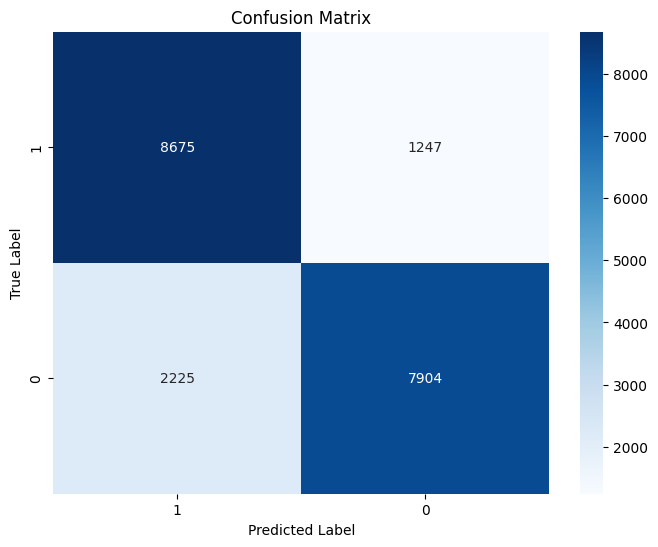

In [41]:
def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)

            test_loss += loss.item()

            predicted = outputs.squeeze().round()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Append labels and predictions for confusion matrix
            all_labels.extend(labels.tolist())
            all_predictions.extend(predicted.tolist())

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)

    print(f'Test Loss: {average_loss:.4f}, Accuracy: {accuracy * 100:.2f}%')

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['1', '0'], yticklabels=['1', '0'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

test_model(model, test_loader, criterion)

In [42]:
torchsummary.summary(model, (1,128), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 128]              64
         AvgPool1d-2               [-1, 16, 64]               0
            Conv1d-3               [-1, 32, 64]           1,568
         AvgPool1d-4               [-1, 32, 32]               0
            Conv1d-5               [-1, 64, 32]           6,208
         AvgPool1d-6               [-1, 64, 16]               0
           Dropout-7                 [-1, 1024]               0
            Linear-8                   [-1, 64]          65,600
            Linear-9                    [-1, 1]              65
Total params: 73,505
Trainable params: 73,505
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.28
Estimated Total Size (MB): 0.36
---------------------------------------------

Spike detected between 0.00 seconds and 0.00 seconds
Spike detected between 0.02 seconds and 0.02 seconds
Spike detected between 0.03 seconds and 0.04 seconds
Spike detected between 0.04 seconds and 0.05 seconds
Spike detected between 0.06 seconds and 0.06 seconds
Spike detected between 0.07 seconds and 0.07 seconds
Spike detected between 0.09 seconds and 0.10 seconds
Spike detected between 0.10 seconds and 0.11 seconds
Spike detected between 0.11 seconds and 0.12 seconds
Spike detected between 0.12 seconds and 0.13 seconds
Spike detected between 0.15 seconds and 0.15 seconds
Spike detected between 0.17 seconds and 0.18 seconds
Spike detected between 0.20 seconds and 0.20 seconds
Spike detected between 0.20 seconds and 0.21 seconds
Spike detected between 0.22 seconds and 0.22 seconds
Spike detected between 0.23 seconds and 0.23 seconds
Spike detected between 0.24 seconds and 0.24 seconds
Spike detected between 0.25 seconds and 0.26 seconds
Spike detected between 0.28 seconds and 0.29 s

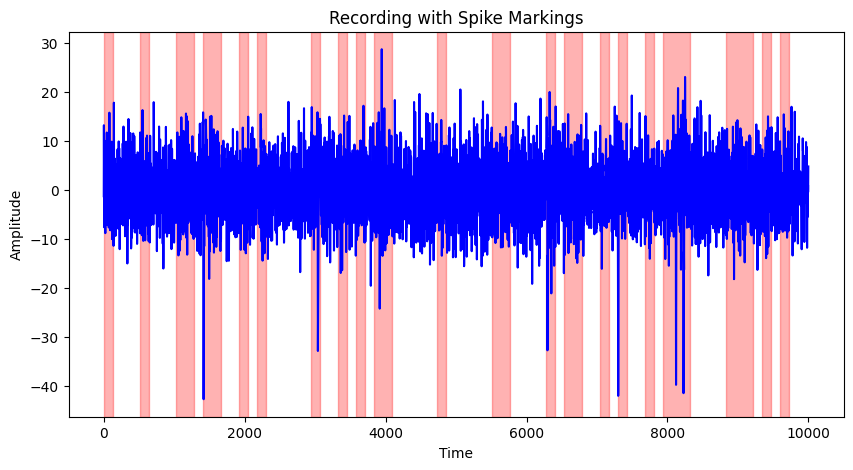

In [32]:
def evaluate_and_plot_chunks(recordings, model, threshold=0.5):
    chunk_size = 128
    num_chunks = len(recordings) // chunk_size
    
    # Initialize arrays to store chunk data and spike flags
    chunk_data = np.zeros((num_chunks, chunk_size))
    spike_flags = np.zeros(num_chunks, dtype=bool)
    
    # Initialize variables to store spike times and spike intervals
    spike_times = []
    spike_intervals = []
    
    # Evaluate each chunk
    for i in range(num_chunks):
        chunk = recordings[i * chunk_size: (i + 1) * chunk_size]
        chunk_data[i] = chunk
        
        # Convert chunk to tensor and pass through model to predict spike
        inputs = torch.tensor(chunk, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        outputs = model(inputs)
        predicted = outputs.squeeze().item()
        spike_flags[i] = predicted > threshold
    
    # Find spike intervals
    is_spiking = False
    start_idx = None
    for i, spike_flag in enumerate(spike_flags):
        if spike_flag and not is_spiking:
            is_spiking = True
            start_idx = i
        elif not spike_flag and is_spiking:
            is_spiking = False
            spike_intervals.append((start_idx * chunk_size, i * chunk_size))
    
    # Plot the recordings and mark spikes
    plt.figure(figsize=(10, 5))
    plt.plot(recordings, color='blue')
    
    # Mark spikes with semitransparent bars
    for interval in spike_intervals:
        plt.axvspan(interval[0], interval[1], color='red', alpha=0.3)
    
    
    for interval in spike_intervals:
        start_time = interval[0] / recgen.info['recordings']['fs']
        end_time = interval[1] / recgen.info['recordings']['fs']
        print(f"Spike detected between {start_time:.2f} seconds and {end_time:.2f} seconds")
    
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Recording with Spike Markings')
    plt.show()


# Usage
example_plot = recgen.recordings[0:10000, 0]
evaluate_and_plot_chunks(example_plot, model)

In [46]:
probe_index = 0 
neurons_within_probe_range = neurons_within_range[probe_index]

# Apply the function to mark spikes on the time series
training_recording = mark_spikes_on_time_series(recgen, probe_index, neurons_within_probe_range)

# Extract spike times from the marked recordings
spike_times_indices = np.where(training_recording[:, 1] == 1)[0]
spike_times = spike_times_indices / recgen.info['recordings']['fs']  # Convert indices to time units


print("Spike times:", spike_times[0:10])

Spike times: [0.00825    0.01203125 0.015625   0.0201875  0.02721875 0.02790625
 0.03778125 0.03859375 0.0425625  0.04425   ]


In [59]:
torch.save(model.state_dict(), 'saved_model.pth')

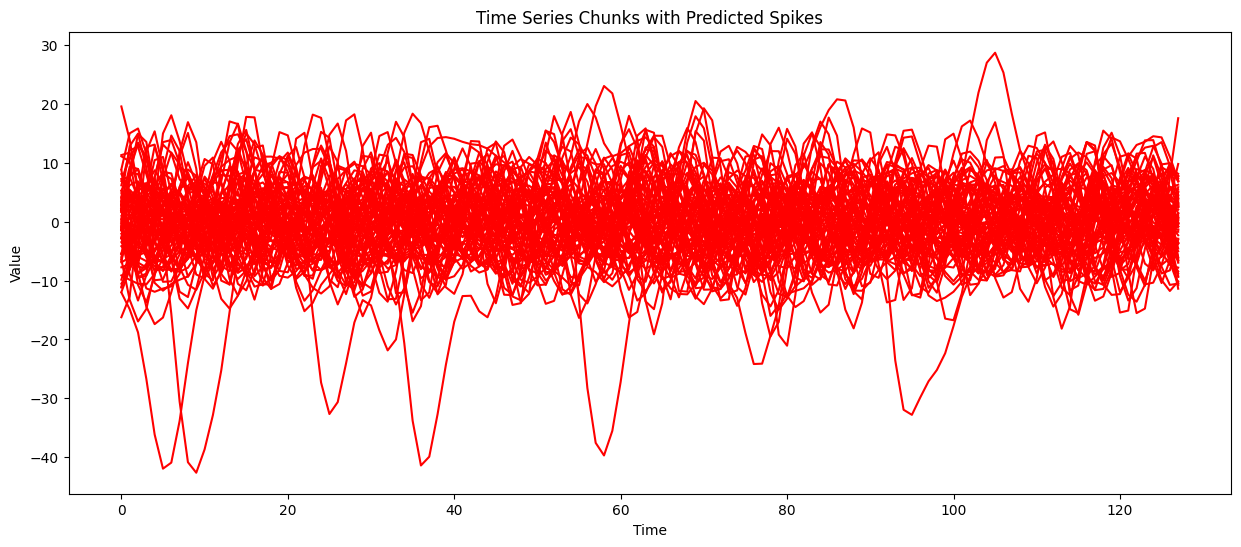

In [57]:
def subsection_time_series(data, chunk_size=128):
    chunks = []
    for i in range(0, len(data), chunk_size):
        chunk = data[i:i + chunk_size]
        if len(chunk) == chunk_size:
            chunks.append(chunk)
    return chunks

# Function to evaluate chunks using the PyTorch CNN model
def evaluate_chunks(chunks, model, threshold):
    device = torch.device("cpu")  # Ensure everything runs on CPU
    predicted_spikes = []
    with torch.no_grad():
        for chunk in chunks:
            # Convert chunk to PyTorch tensor
            chunk_tensor = torch.tensor(chunk, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            
            # Perform inference
            output = model(chunk_tensor)
            
            # Assuming your model output is a probability of spike occurrence
            # You may need to adjust this depending on your model's output
            prediction = torch.sigmoid(output).numpy().squeeze()  # Adjust this line based on your model's output
            
            # Check if the prediction indicates a spike (you need to define this logic based on your model output)
            if prediction > threshold:  # Adjust threshold as needed
                predicted_spikes.append(True)
            else:
                predicted_spikes.append(False)
    return predicted_spikes

# Subsection the time series data into 128-unit chunks
chunks = subsection_time_series(recgen.recordings[0:10000, 0])

# Define the threshold for predicting a spike
threshold = 0.5  # Adjust this as needed

# Evaluate the chunks using the PyTorch CNN model
predicted_spikes = evaluate_chunks(chunks, model, threshold)

# Plot the chunks where the PyTorch CNN model predicted a spike
plt.figure(figsize=(15, 6))
for i, chunk in enumerate(chunks):
    if predicted_spikes[i]:
        plt.plot(chunk, color='red')  # Plot in red if predicted spike
    else:
        plt.plot(chunk, color='blue')  # Plot in blue if no predicted spike
plt.title('Time Series Chunks with Predicted Spikes')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

In [51]:
threshold = 0.5

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

In [60]:
selected_indices_without_spike

array([ 9999,  8293,  4123, ...,  5684,  2657, 10130])

In [62]:
np.where(selected_chunks_with_spike != 0)

(array([    0,     0,     0, ..., 18846, 18846, 18846]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([ 24,  36,  84, ...,  54,  80, 102]))

In [64]:
selected_chunks_with_spike.shape

(18847, 1, 128)

In [65]:
chunks_without_spike

array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]]])

In [66]:
spike_chunks

array([[[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 1., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.]]])